# Experiments carried out applying the RR dRR intervals method

In [1]:
# Load NeuroKit and other useful packages
import neurokit2 as nk #TODO look into this algorithm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import scipy
from tqdm import tqdm

#### Function to bin RR dRR points into grids

In [2]:
def assign_to_grid(points, plotting=False):
    """
    Function which calculates the population of points in each grid section, and 
    can plot these as saturation of colours in the grid. 
    """
    # find sum of no_points in each grid section 
    grid_count = np.zeros((RR_dimensions, dRR_dimensions))
    
    for n_,point in enumerate(points):

        RR_val = point[0]
        dRR_val = point[1]

        for i in range(RR_dimensions-1): # scanning RR direction 
            if RR_val > RR_points[i] and RR_val <= RR_points[i+1]:
                for j in range(dRR_dimensions-1): # scanning dRR direction
                    if dRR_val > dRR_points[j] and dRR_val <= dRR_points[j+1]:
                        grid_count[i,j] += 1

                        # colour in the grid_sections with intensity of colour corresponding to the count of points in that section 
                        if plotting:
                            plt.fill_between(RR_points, [dRR_points[j+1]]*RR_dimensions, [dRR_points[j]]*RR_dimensions, 
                                             where=[(RR_point == RR_points[i]) or (RR_point == RR_points[i+1]) for RR_point in RR_points],
                                             alpha = 5/len(points), color='b')

    return grid_count


#### Draw the grid 

In [3]:
show_ecg = False
plot_grid = False

### Genereate the grid, range values should be universally applicable although this will need to be tested across different dataset
# TODO check these ranges
RR_range = (0, 500)
dRR_range = (-300, 300)
RR_dimensions = int((RR_range[1] - RR_range[0])/25)
square_length = int((RR_range[1] - RR_range[0]) / RR_dimensions)
dRR_dimensions = int((dRR_range[1] - dRR_range[0]) / square_length)
RR_points = np.linspace(RR_range[0],RR_range[1], RR_dimensions)
dRR_points = np.linspace(dRR_range[0],dRR_range[1],dRR_dimensions)
if plot_grid:
    plt.vlines(RR_points, dRR_range[0], dRR_range[1])
    plt.hlines(dRR_points, RR_range[0], RR_range[1])
grid_points = np.meshgrid(RR_points, dRR_points)

#### Generate grid count data for dataset provided

In [4]:
def generate_grid_count_data_for_dataset(path_to_dataset, grid_counting_data, filetype_options=[".mat", ".npy", ".dat"]):
    """
    For each ECG in the dataset provided, calculate the count of each grid section of 
    number of RR dRR points found from the ECG in that grid section
    """
    
    filenames_to_filetype_dict = {}
    filenames = []
    
    for filetype in filetype_options:
        
        filenames_for_type = [file.split(filetype,2)[0] for file in os.listdir(path_to_dataset) if file.endswith(filetype)]
        filenames_to_this_filetype_dict = {filename: filetype for filename in filenames_for_type}
        
        filenames_to_filetype_dict.update(filenames_to_this_filetype_dict)
        for filename in filenames_for_type: filenames.append(filename)
            
    
    try:
        for filename in tqdm([filename for filename in filenames if filename not in list(grid_counting_data.keys())]):

            filetype = filenames_to_filetype_dict[filename]
            
            if filetype == ".mat":
                ecg_signal = scipy.io.loadmat(f"{path_to_dataset}\\{filename}.mat")['val'][0]
                ecg_signal = ecg_signal / np.max(ecg_signal) # normalise
            
            elif filetype == ".npy":
                ecg_signal = np.load(f"{path_to_dataset}\\{filename}.npy")
            
            elif filetype == ".dat":
                record = wfdb.rdrecord(os.path.join(path_to_dataset, filename))
                ecg_signal = record.p_signal.T[0]

                
            
            # Extract R-peaks locations
            try:
                _, rpeaks = nk.ecg_peaks(ecg_signal, sampling_rate=300)
            except IndexError:
                print(f"unable to find peaks in file {filename}")
                continue

            # Calculate the RR and dRR values
            R_peaks = rpeaks['ECG_R_Peaks']
            RR = (np.pad(R_peaks, (0,1))[1:] - R_peaks)[:-1]
            dRR = (np.pad(RR, (0,1))[1:] - RR)[:-1]
            RR = RR[1:]

            # Calculate the grid population proportions
            points = list(zip(RR,dRR))
            grid_count = assign_to_grid(points, plotting=plot_grid)
            proportion_grid_sections_non_zero_count = np.nonzero(grid_count)[0].shape[0]/grid_count.size
            grid_counting_data[filename] = proportion_grid_sections_non_zero_count

        return grid_counting_data
    
    except KeyboardInterrupt:
        return grid_counting_data


In [5]:
%store -r grid_counting_data_2017

In [6]:
path_to_2017_dataset = "2_data\\physionet_datasets\\training2017\\"
grid_counting_data_2017 = generate_grid_count_data_for_dataset(path_to_2017_dataset, grid_counting_data_2017)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.57it/s]

unable to find peaks in file A07983


In [7]:
# %store grid_counting_data_2017

### Visualise the sample which failed in R detection

In [8]:
import wfdb

def show_sample_ecg(path_to_sample):
    sample_to_visualise = path_to_sample.split("\\")[-1].split('.mat',2)[0] 
    record = wfdb.rdrecord(path_to_sample.split('.mat',2)[0], channels=[0])
    wfdb.plot_wfdb(record=record, plot_sym=True, time_units='seconds')

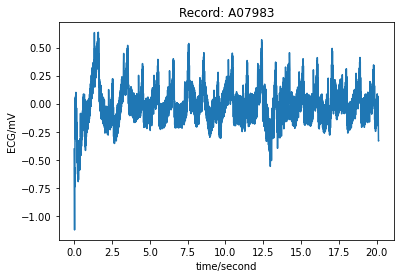

In [9]:
show_sample_ecg("2_data\\physionet_datasets\\training2017\\A07983.mat") 

### TODO


Thresholding, check threshold values, maybe optimise (therefore training).

Get reuslt on 2017

regression maybe,

Apply to 2020 (specifically the holter dataset not 

# Results of grid count

In [10]:
labels_df = pd.read_csv("2_data\\physionet_datasets\\training2017\\REFERENCE.csv", names=["filename","label"])

## Plot all data from grid_counting_data to see if thresholding will work



#### Prepare data and labels/colours etc for plots

In [11]:
def get_label(filename):
    return labels_df[labels_df["filename"] == filename].label.item()
    
# sorted_data = {k: v for k, v in sorted(grid_counting_data.items(), key=lambda item: item[1])}
labels_2017 = {filename: get_label(filename) for filename in grid_counting_data_2017.keys()}

In [12]:
colour_key = {"N": "g", "O": "b", "A": "r", "~": "grey"}
size_key = {"N": 5, "O": 5, "A": 5, "~": 5}

In [13]:
average_values_for_each_category_2017 = [np.mean(np.array([grid_counting_data_2017[filename] for filename in labels_2017.keys() if labels_2017[filename] == label])) for label in colour_key.keys()]
average_values_for_each_category_2017 = dict(zip(colour_key.keys(),average_values_for_each_category_2017))

#### Function for plotting the grid count data 

In [14]:
from matplotlib.lines import Line2D

In [15]:
def plot_grid_count_data_and_averages(grid_counting_data, labels, colour_key, size_key, average_values_for_each_category):
    
    # plot format stuff
    plt.rcParams["figure.figsize"] = (20,6)
    plt.rcParams['figure.dpi'] = 300

    # find data and visual metadata for plotting
    x = np.arange(len(grid_counting_data))
    y = list(grid_counting_data.values())
    colours = [colour_key[labels[filename]] for filename in grid_counting_data.keys()]
    sizes = [size_key[labels[filename]] for filename in grid_counting_data.keys()]
    
    # plot and produce legend and axes labels
    plt.scatter(x, y, s=sizes, c=colours)
    plt.xlabel("sample")
    plt.ylabel("proportion of grids populated")
    plt.title("Scatter plot of 2017 dataset values from grid counting method, colour coded with labels, mean values plotted")

    custom_lines = [Line2D([0], [0], color=colour_, lw=4) for colour_ in colour_key.values()]
    plt.legend(custom_lines, [key for key in colour_key.keys()])
    
    # plot average values
    for label, average_value in average_values_for_each_category.items():
        plt.hlines(average_value, 0, len(grid_counting_data), color=colour_key[label], linewidths=5)

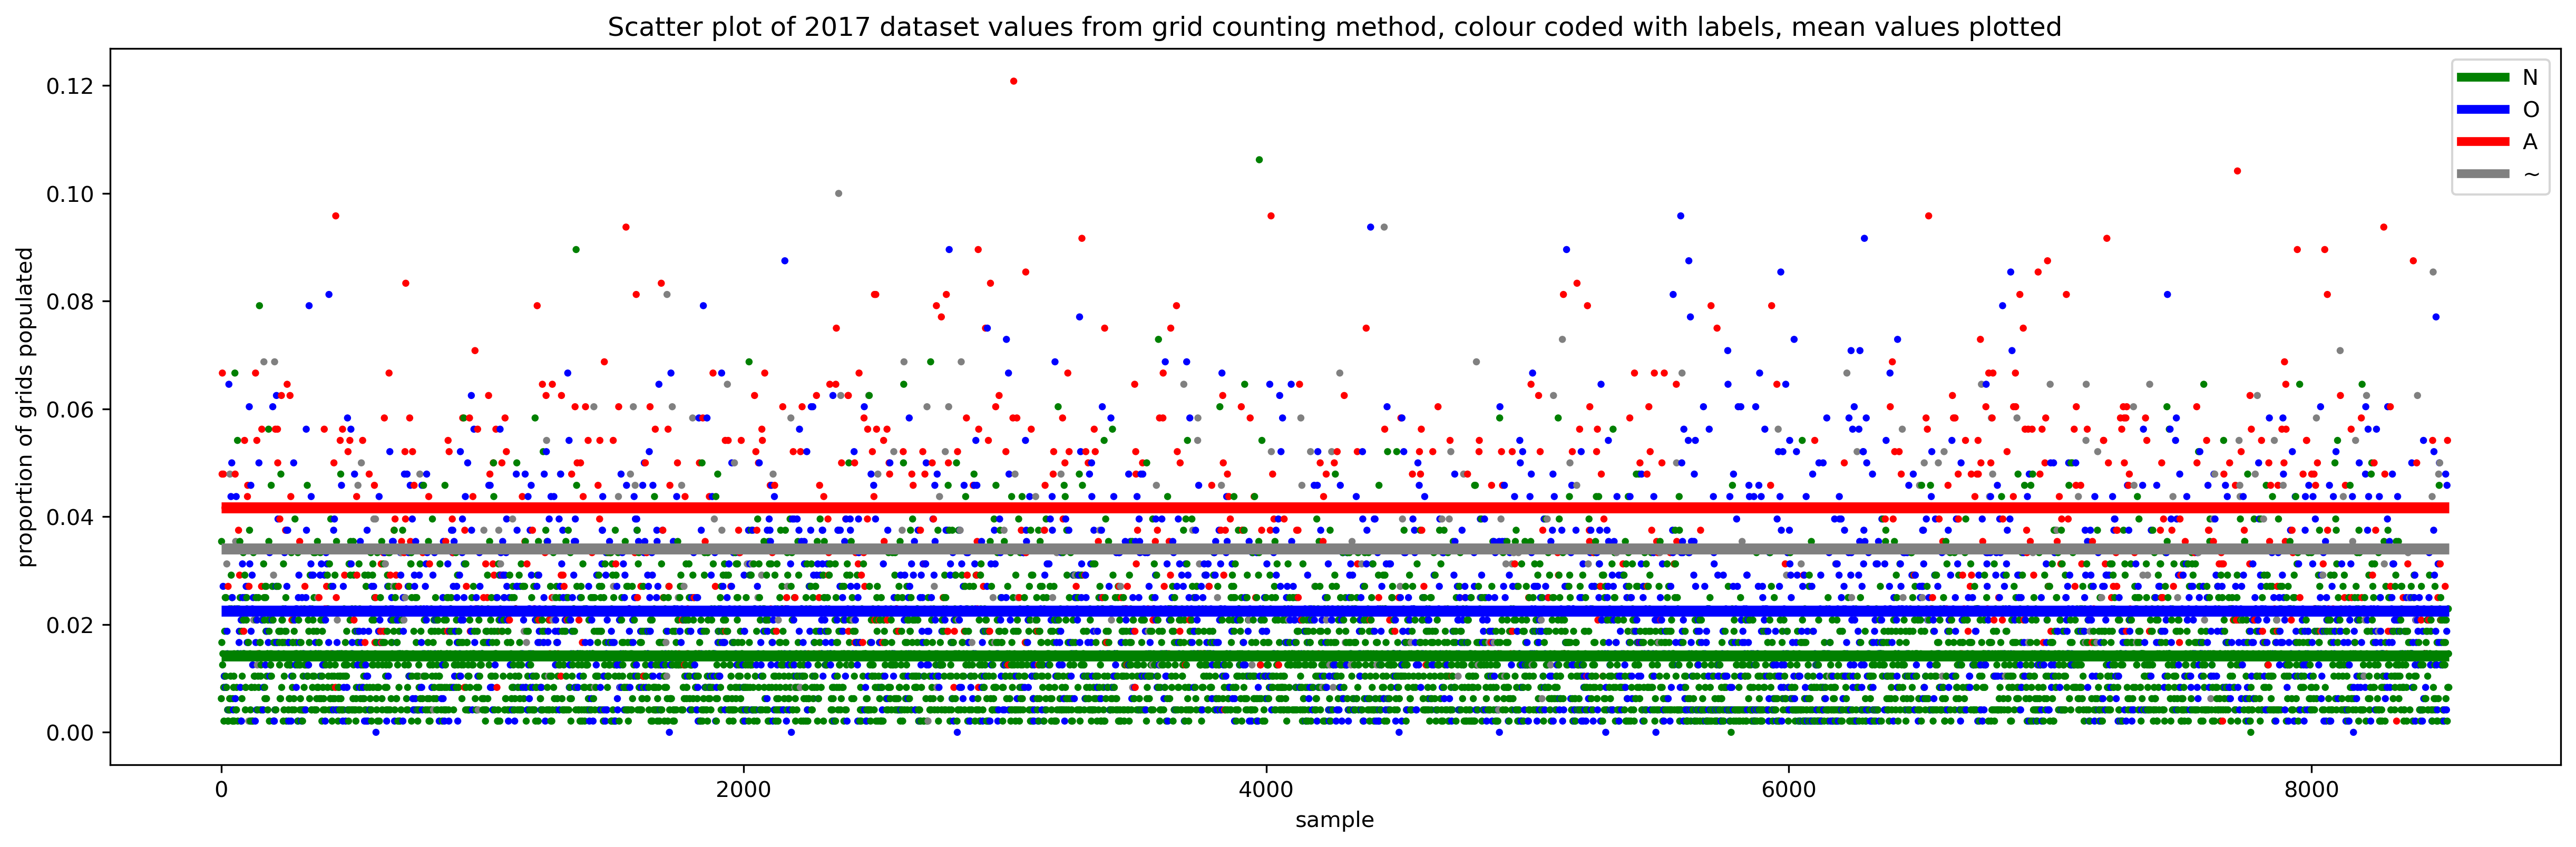

In [16]:
plot_grid_count_data_and_averages(grid_counting_data_2017, labels_2017, colour_key, size_key, average_values_for_each_category_2017)

## Optimising threshold value

In order to train this method, optimising the threshold value which is the value at which if the proportion of grids populated is above, the sample is labelled as 'A', whereas if it is below it is labelled as 'Non A' 

#### Prepare the data for training

In [17]:
# remove noisy samples 
grid_counting_data_2017 = {k: v for k,v in grid_counting_data_2017.items() if labels_2017[k] != "~"}

In [18]:
# reformat the labels to just binary classification of either AF or not AF
def binary_classification_converter(label):
    if label == 'A': # AF
        return 'A'
    else: # not AF
        return 'N'

label_data_2017_binary_classification = {k: binary_classification_converter(label) for k,label in labels_2017.items() if label != "~"}

#### Define the function to call the threshold method

In [19]:
def produce_predictions_based_on_threshold(proposal_threshold, **kwargs):
    """
    Function to produce predictions array for supplied data by simply 
    predicting that any ECG with grid count proportion above the 
    provided threshold is AF, or below threshold is Non AF
    """
    
    
    # produce array of all x values
    arr_grid_count_data = np.array(list(kwargs["grid_count_data_dict"].items()), dtype=object)
    
    # find indices of ECGs which should be diagnosed as AF or non AF 
    indices_AF = np.where(arr_grid_count_data.T[1] >= proposal_threshold)[0]
    indices_non_AF = np.delete(np.arange(arr_grid_count_data.shape[0]), indices_AF)
    
    # produce predictions array
    predictions = np.zeros((arr_grid_count_data.shape), dtype=object)
    predictions[:,0] = arr_grid_count_data[:,0]
    predictions[indices_AF,1] = "A"
    predictions[indices_non_AF,1] = "N"
    
    return predictions

### Design a cost function for training the threshold value

In [20]:
def cost_function(w, **kwargs):
    """
    Cost function for training the model, which is simply a weighted sum 
    of incorrect labels, with more weight given to false negatives than 
    false positives, to prevent model just fitting very well to predicting 
    Non AF, which will most often be correct because the dataset is heavily 
    skewed towards Non AF.
    """
    
    predictions = kwargs["model_call_function"](w, **kwargs)    
    cost = 0
    
    for filename, prediction in predictions:
        # print(round(grid_proportion_value, 5), proposal_threshold, prediction, label_data_dict[filename])
        ground_truth_label = kwargs["label_data_dict"][filename]
        if prediction != ground_truth_label:
            if prediction == 'A' and ground_truth_label == 'N': # false positive AF diagnosis
                cost += 1
            elif prediction == 'N' and ground_truth_label == 'A': #  false negative AF diagnosis
                cost += 5
    
    return cost

In [21]:
kwargs = {"model_call_function": produce_predictions_based_on_threshold, 
          "grid_count_data_dict": grid_counting_data_2017, 
          "label_data_dict": label_data_2017_binary_classification}

cost_function(0.01, **kwargs)

5057

initially a cost function which gave equal weighting to type I and type II error was used, but this led to higher threshold value because cost of having this higher value and missing some AF labels was minimal, because they are a lot less frequent in the dataset anyway.

### TODO 

experiment with this cost fucntion 
experiment with changing dataset for better representation of AF 

### Plot the cost function over different threshold values

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 95.23it/s]


(0.034, 2137)

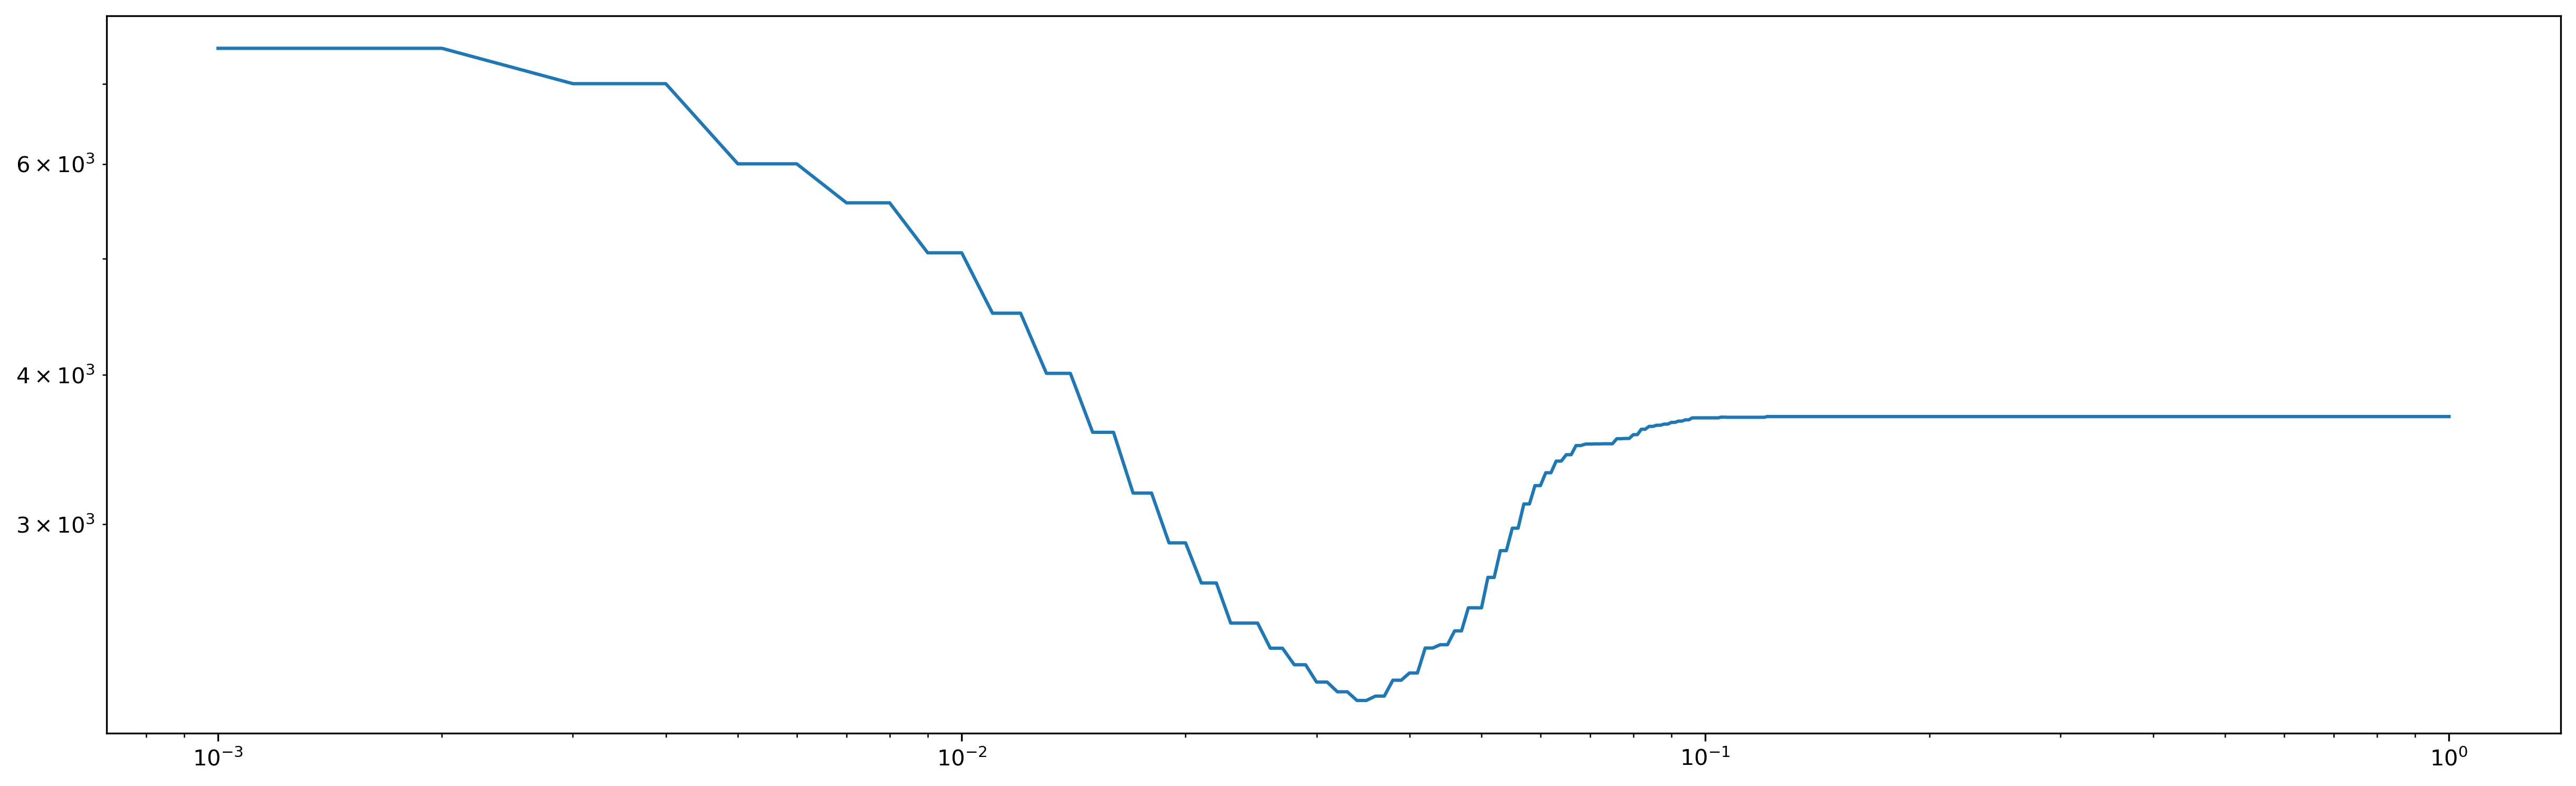

In [22]:
threshold_values_for_cost_minimisation = np.linspace(1e-3, 1e0, 1000)
cost_values = [cost_function(threshold, **kwargs) for threshold in tqdm(threshold_values_for_cost_minimisation)]
plt.plot(threshold_values_for_cost_minimisation, cost_values)
plt.xscale('log')
plt.yscale('log')
threshold_values_for_cost_minimisation[np.argmin(np.array(cost_values))], min(cost_values)

In [23]:
from scipy.optimize import minimize

In [24]:
# min_x_found = minimize(cost_function, 0.5, args=(kwargs)).x
min_threshold_found_cost_method = threshold_values_for_cost_minimisation[np.argmin(cost_values)]

This isnt working properly yet

##### Currently use minimum found by logarithmic grid search

0.034

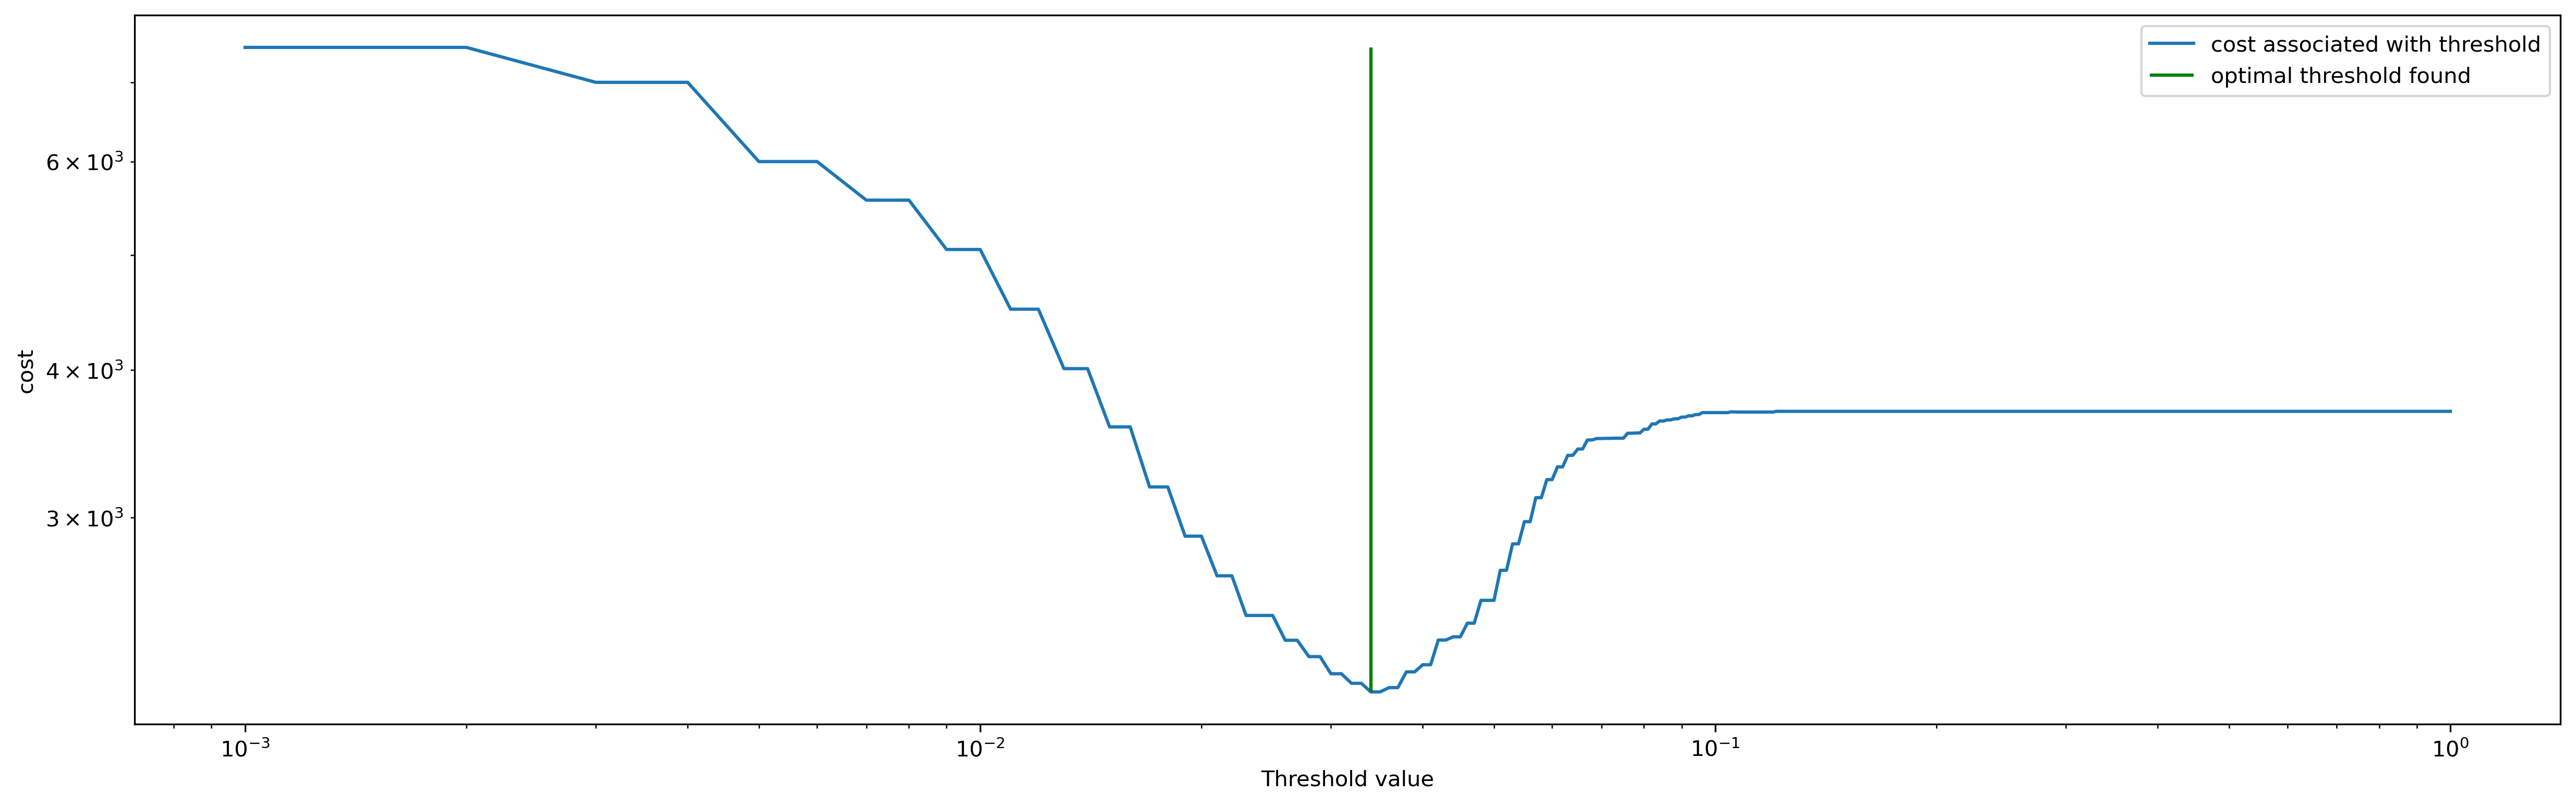

In [25]:
plt.plot(threshold_values_for_cost_minimisation, cost_values, label="cost associated with threshold")
plt.xscale('log')
plt.yscale('log')
plt.vlines(min_threshold_found_cost_method, min(cost_values), max(cost_values), color='g', label="optimal threshold found")
plt.xlabel("Threshold value")
plt.ylabel("cost")
plt.legend()
min_threshold_found_cost_method

Value chosen for threshold is 0.034

### A quick investigation into most efficient method for producing predictions to be used in the training process

In [26]:
def threshold_based_prediction(threshold, grid_count_data_dict):
    return np.array([[filename, "A"] if val >= threshold else [filename, "N"] for filename, val in grid_count_data_dict.items()])

In [27]:
import time

In [28]:
time_1_values = []
time_2_values = []

for i in range(100):
    threshold = 0.034
    start_1 = time.time()
    predictions = threshold_based_prediction(threshold, grid_counting_data_2017)
    end_1 = time.time()
    time_1 = end_1 - start_1

    start_2 = time.time()
    predictions = produce_predictions_based_on_threshold(threshold, **{"grid_count_data_dict": grid_counting_data_2017})
    end_2 = time.time()
    time_2 = end_2 - start_2

    arr_labels = np.array([[filename, label] for filename, label in label_data_2017_binary_classification.items()])
    time_1_values.append(time_1)
    time_2_values.append(time_2)

(0.008981847763061523, 0.0038667893409729003)

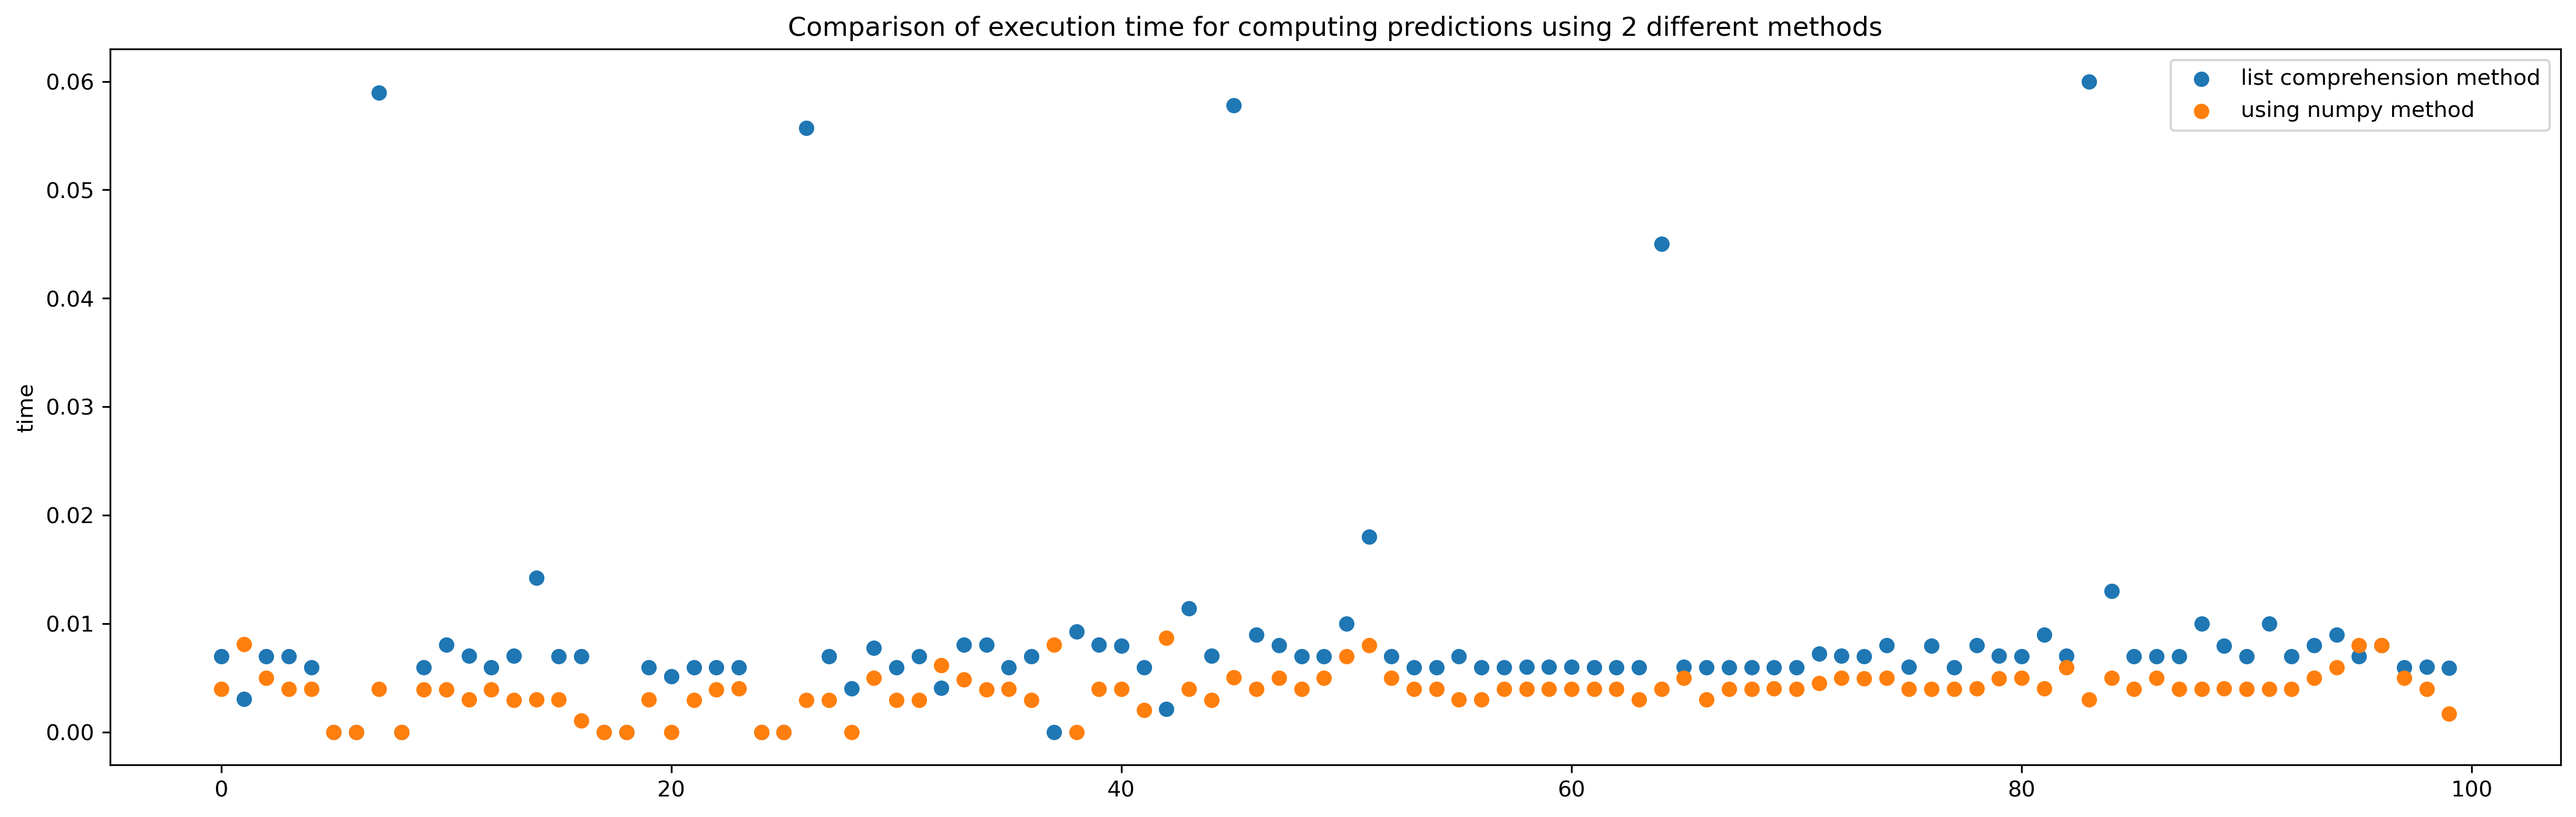

In [29]:
plt.scatter(np.arange(100), time_1_values, label="list comprehension method")
plt.scatter(np.arange(100), time_2_values, label="using numpy method")
plt.title("Comparison of execution time for computing predictions using 2 different methods")
plt.legend()
plt.ylabel("time")
np.mean(np.array(time_1_values)), np.mean(np.array(time_2_values))

Clearly the best method is using numpy extensively, as expected

## Calculate the F1 score for predictions

In [30]:
from utils.performance_metrik import find_f1_score

In [31]:
def find_f1_score(predictions, labels):
    """
    Calculates performance metriks for 'A' or 'N' categorisation from provided
    predictions and labels numpy arrays.
    
    returns:
        (f1_score: float, precision: float, recall: float)
    """
    
    assert predictions.shape[0] == predictions.shape[0]
    
    N = predictions.shape[0]
    
    arr_predictions_labels_only = np.zeros((N,2), dtype=str)
    counter = 0
    for filename, pred_ in predictions:
        label_ = labels[labels[:,0] == filename][0][1]
        arr_predictions_labels_only[counter, 0] = label_ 
        arr_predictions_labels_only[counter, 1] = pred_
        counter += 1
    
    tp = 0 # no. true positives
    fp = 0 # no. false positives
    fn = 0 # no. false negatives
    tn = 0 # no. true negatives
    
    for prediction_label_pair in arr_predictions_labels_only:
        pred, lab = prediction_label_pair
        if pred == "N" and lab == "N": tn += 1
        elif pred == "A" and lab == "A": tp += 1
        elif pred == "N" and lab == "A": fn += 1
        elif pred == "A" and lab == "N": fp += 1
    
    
    # Calculate accuracy metriks for AF diagnosis
    if tp == 0:
        f1_score_A = 0 
        precision_A = 0
        recall_A = 0
    else:
        precision_A = tp / (tp + fp)
        recall_A = tp / (tp + fn)
        f1_score_A = 2 / ( recall_A**(-1) + precision_A**(-1) )

    # Calculate accuracy metriks for Not AF diagnosis
    if tn == 0:
        f1_score_N = 0 
        precision_N = 0
        recall_N = 0
    else:
        precision_N = tn / (tn + fn)
        recall_N = tn / (tn + fp)
        f1_score_N = 2 / ( recall_N**(-1) + precision_N**(-1) )   
        
    # return results 
    return [("A_values:", f1_score_A, precision_A, recall_A), (("N_values:", f1_score_N, precision_N, recall_N))]


In [32]:
predictions = produce_predictions_based_on_threshold(threshold, **{"grid_count_data_dict": grid_counting_data_2017})
find_f1_score(predictions, arr_labels)

[('A_values:', 0.47387480600103465, 0.6205962059620597, 0.3832635983263598),
 ('N_values:', 0.9301271040879422, 0.9018118838262723, 0.9602780536246276)]

Clearly this threshold is not accurate enough for detecting AF, with very low values of F1 score, precision and recall when used. An attempt will now be made to to use this F1 score as the new cost function for optimising this threshold value.

## Optimise threshold by F1 score of AF diagnosis

In [33]:
def f1_score_cost_function(threshold, grid_count_data_dict, label_data):
    predictions_ = produce_predictions_based_on_threshold(threshold, **{"grid_count_data_dict": grid_count_data_dict})
    arr_labels = np.array([[filename, label] for filename, label in label_data.items()])
    f1_scores = find_f1_score(predictions_, arr_labels)
    for diagnosis_score in f1_scores:
        if diagnosis_score[0] == "A_values:":
            return diagnosis_score[1]
        

In [34]:
f1_score_cost_function(threshold, grid_counting_data_2017, label_data_2017_binary_classification)

0.47387480600103465

In [35]:
def plot_threshold_found_using_f1_method(grid_count_data_dict, label_data_2017_binary_classification):
    threshold_values_f1_minimisation_method = np.linspace(1e-2, 0.12, 100)
    f1_values = [f1_score_cost_function(threshold, grid_count_data_dict, label_data_2017_binary_classification) for threshold in tqdm(threshold_values_f1_minimisation_method)]
    best_threshold_found_f1_method = threshold_values_f1_minimisation_method[np.argmax(np.array(f1_values))]
    plt.plot(threshold_values_f1_minimisation_method, f1_values)
    plt.xscale('log')
    plt.yscale('log')
    plt.vlines(min_threshold_found_cost_method, min(f1_values), max(f1_values), color="g", label="optimal threshold found with cost method")
    plt.vlines(best_threshold_found_f1_method, min(f1_values), max(f1_values), color="r", label="optimal threshold found with f1 method")
    plt.legend()
    return best_threshold_found_f1_method, f1_values

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:00<00:00,  1.66it/s]


(0.04,
 [0.2250347275814169,
  0.24567356633864948,
  0.24567356633864948,
  0.2673896783844428,
  0.2673896783844428,
  0.28975853455453787,
  0.28975853455453787,
  0.3153257593322513,
  0.3383497664763882,
  0.3383497664763882,
  0.35964151488869617,
  0.35964151488869617,
  0.3839228295819936,
  0.3839228295819936,
  0.40372893510218716,
  0.40372893510218716,
  0.42071965203637807,
  0.42071965203637807,
  0.44010416666666663,
  0.44010416666666663,
  0.4558754129306276,
  0.4558754129306276,
  0.47387480600103465,
  0.48035417819590476,
  0.48035417819590476,
  0.48009650180940894,
  0.48009650180940894,
  0.48355899419729215,
  0.48355899419729215,
  0.46887966804979253,
  0.46887966804979253,
  0.47387785136129507,
  0.47387785136129507,
  0.4659890539483971,
  0.4659890539483971,
  0.44352159468438546,
  0.44352159468438546,
  0.40530973451327434,
  0.3648269410664172,
  0.3648269410664172,
  0.32517140058765914,
  0.32517140058765914,
  0.2760041194644696,
  0.276004119464469

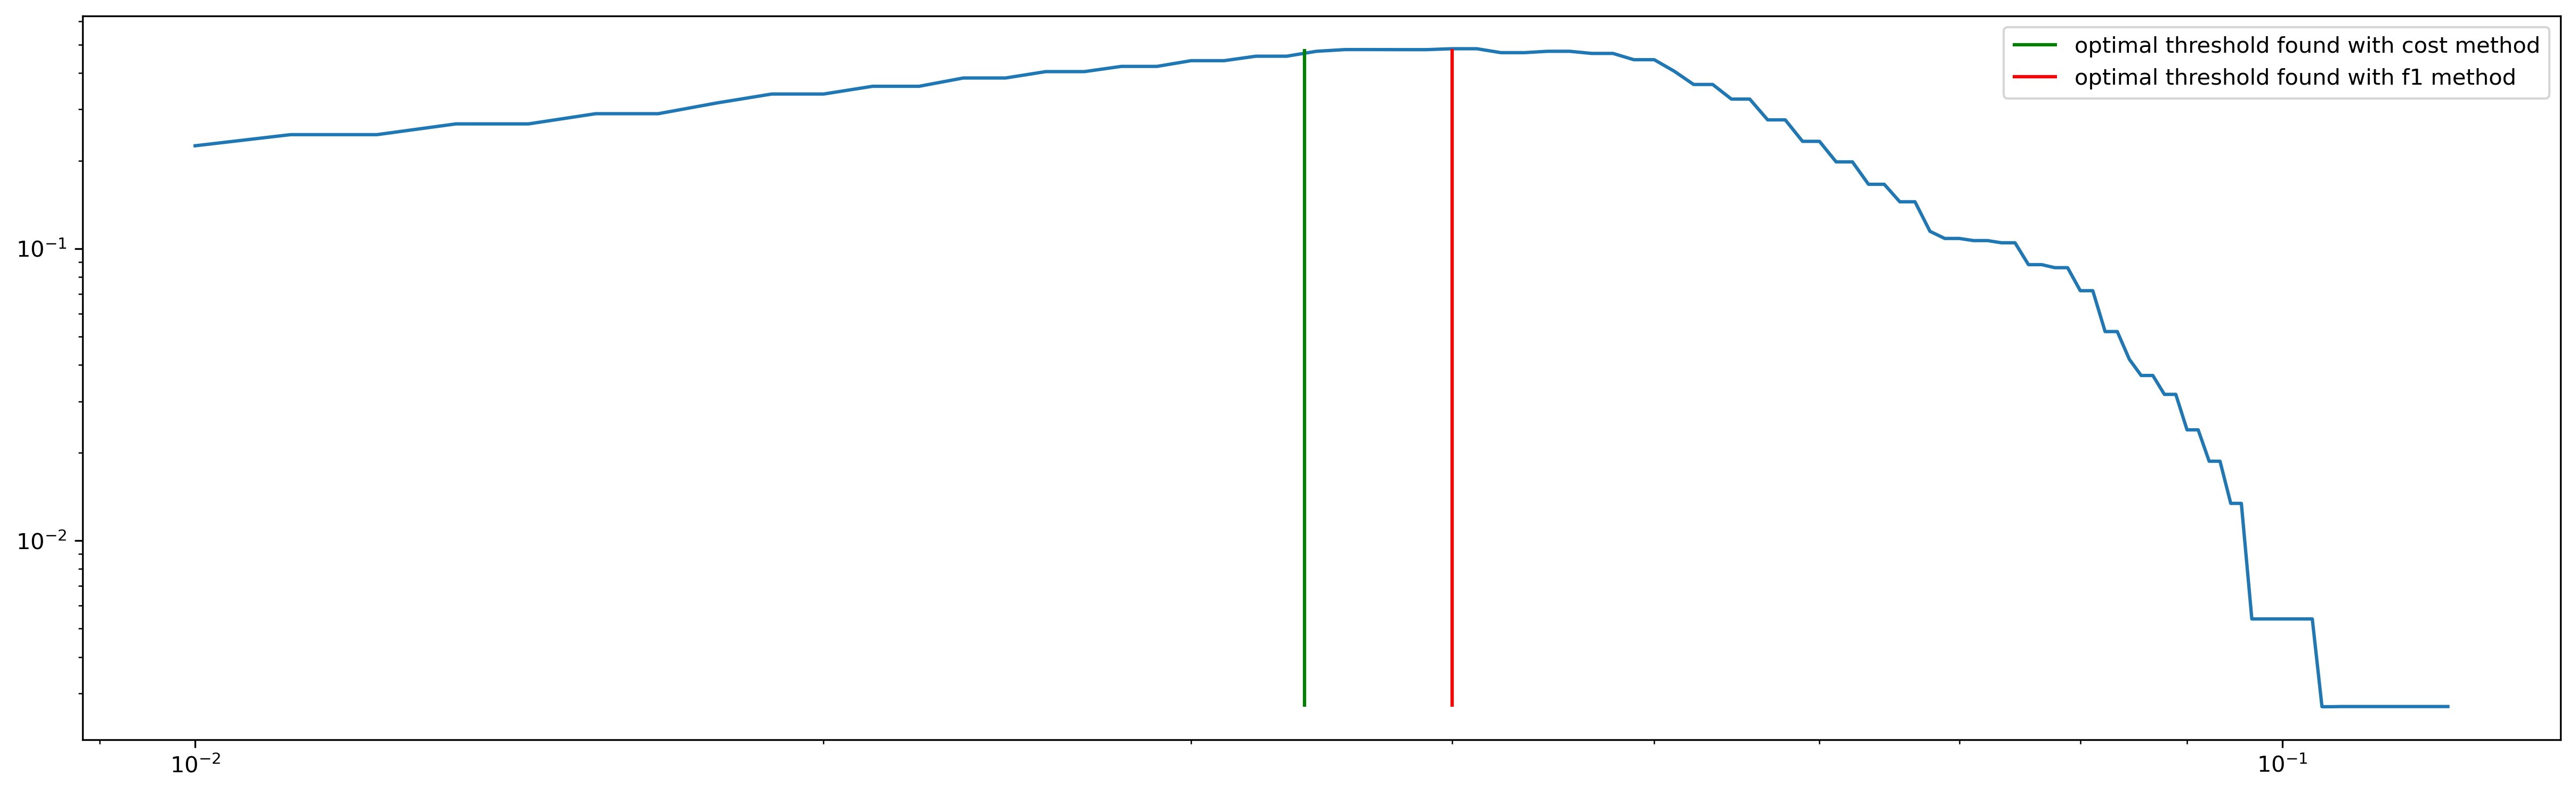

In [36]:
# best_threshold_found_f1_method, f1_values = plot_threshold_found_using_f1_method(grid_counting_data_2017, label_data_2017_binary_classification)
# best_threshold_found_f1_method

best threshold from this method is 0.04

## Confusion matrix calculation for 2017 dataset

In [45]:
from sklearn.metrics import confusion_matrix

In [46]:
y_true = [2, 0, 2, 2, 0, 1]
y_pred = [0, 0, 2, 2, 0, 2]
confusion_matrix(y_true, y_pred)

array([[2, 0, 0],
       [0, 0, 1],
       [1, 0, 2]], dtype=int64)

In [76]:
predictions_2017 = produce_predictions_based_on_threshold(threshold, **{"grid_count_data_dict": grid_counting_data_2017}).tolist()
labels_2017 = [[filename, label] for filename, label in label_data_2017_binary_classification.items()]

# pred_ = [0 if pred_[1] == "N" else 1 for pred_ in predictions_2017]
# labels_ = [0 if label_[1] == "N" else 1 for label_ in labels_2017]
confusion_matrix([lab_[1] for lab_ in labels_2017], [pred_[1] for pred_ in predictions_2017])

array([[ 458,  280],
       [ 737, 6769]], dtype=int64)

# Load MIT-BIH dataset

In [37]:
%store -r grid_counting_data_mit_bih_AF
%store -r grid_counting_data_mit_bih_N
# grid_counting_data_mit_bih_AF = {}
# grid_counting_data_mit_bih_N = {}

In [38]:
grid_counting_data_mit_bih_AF = generate_grid_count_data_for_dataset("2_data\\physionet_datasets\\mitbih\\af_dataset\\experimental_split_ecgs", grid_counting_data_mit_bih_AF)
grid_counting_data_mit_bih_N = generate_grid_count_data_for_dataset("2_data\\physionet_datasets\\mitbih\\normal_dataset\\split_ecgs", grid_counting_data_mit_bih_N)

0it [00:00, ?it/s]
0it [00:00, ?it/s]


In [39]:
# %store grid_counting_data_mit_bih_AF
# %store grid_counting_data_mit_bih_N


In [40]:
def get_label_from_filename(filename):
    if "221" in filename or "210" in filename:
        return "A"
    else:
        return "N"
    
    
# labels_mitbih = {filename: get_label_from_filename(filename) for filename in grid_counting_data_split_ecgs.keys()}
# labels_mitbih = {filename: ("A" if filename.endswith("AF") else "N") for filename in grid_counting_data_mit_bih_AF.keys()}
labels_mitbih = {filename: "A" for filename in grid_counting_data_mit_bih_AF.keys()} 
labels_mitbih.update({filename: "N" for filename in grid_counting_data_mit_bih_N.keys()}) 

grid_counting_data_mit_bih_total = grid_counting_data_mit_bih_AF
grid_counting_data_mit_bih_total.update(grid_counting_data_mit_bih_N)

In [41]:
average_values_for_each_category_mitbih = [np.mean(np.array([grid_counting_data_mit_bih_total[filename] for filename in labels_mitbih.keys() if labels_mitbih[filename] == label])) for label in colour_key.keys()]
average_values_for_each_category_mitbih = dict(zip(colour_key.keys(), average_values_for_each_category_mitbih))

C:\Users\Jordan\Anaconda3\envs\tf-NNN-build\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Jordan\Anaconda3\envs\tf-NNN-build\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


C:\Users\Jordan\Anaconda3\envs\tf-NNN-build\lib\site-packages\matplotlib\axes\_base.py:2475: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


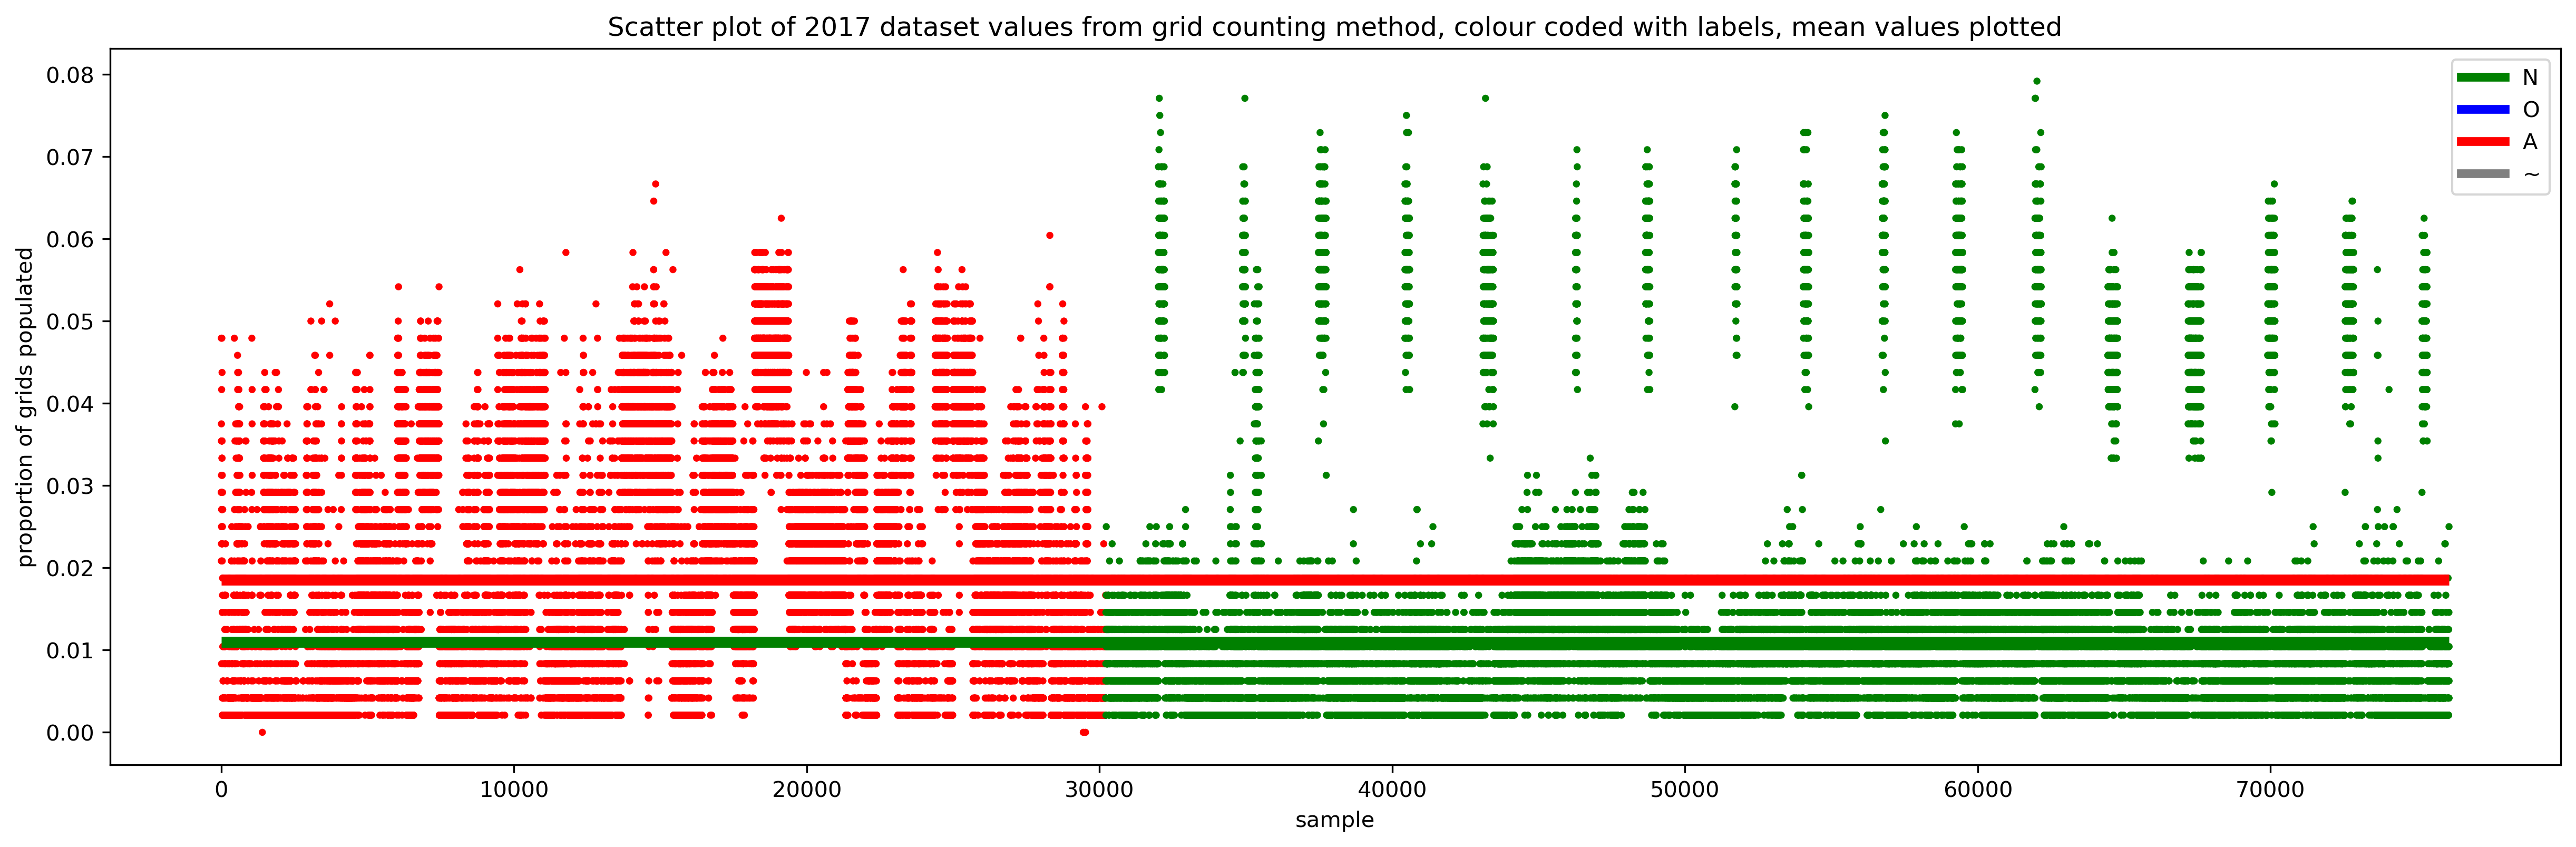

In [42]:
plot_grid_count_data_and_averages(grid_counting_data_mit_bih_total, labels_mitbih, colour_key, size_key, average_values_for_each_category_mitbih)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:59<00:00,  8.34it/s]


(0.001, 45903)

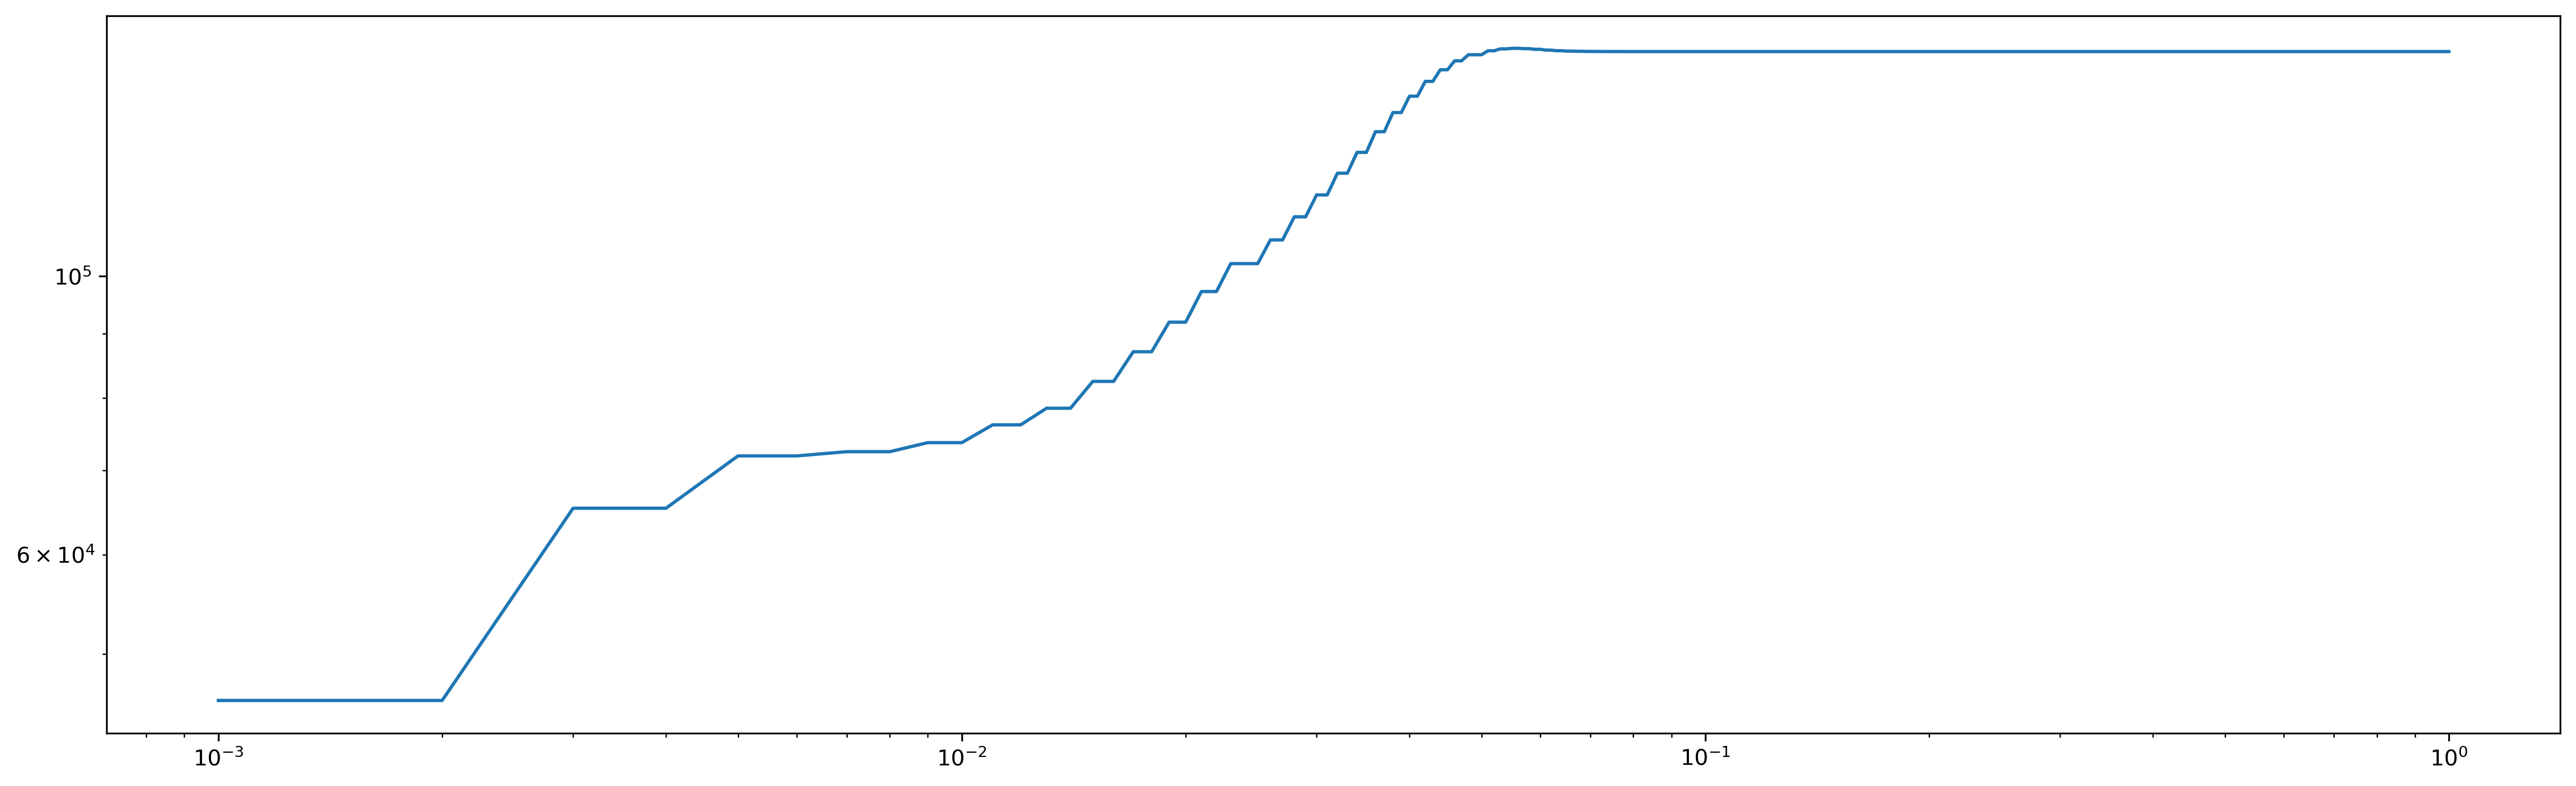

In [43]:
kwargs = {"model_call_function": produce_predictions_based_on_threshold, 
          "grid_count_data_dict": grid_counting_data_mit_bih_total, 
          "label_data_dict": labels_mitbih}

threshold_values_for_cost_minaimisation = np.linspace(1e-3, 1e0, 1000)
cost_values = [cost_function(threshold, **kwargs) for threshold in tqdm(threshold_values_for_cost_minimisation)]
plt.plot(threshold_values_for_cost_minimisation, cost_values)
plt.xscale('log')
plt.yscale('log')
threshold_values_for_cost_minimisation[np.argmin(np.array(cost_values))], min(cost_values)

For MIT-BIH dataset there is a minimum cost threshold value of 2e-2

In [44]:
# plot_threshold_found_using_f1_method(grid_counting_data_mit_bih_total, labels_mitbih)

  3%|██▍                                                                             | 3/100 [03:33<1:55:08, 71.23s/it]ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\Jordan\Anaconda3\envs\tf-NNN-build\lib\site-packages\IPython\core\interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\Jordan\AppData\Local\Temp/ipykernel_177284/2843012354.py", line 1, in <module>
    plot_threshold_found_using_f1_method(grid_counting_data_mit_bih_total, labels_mitbih)
  File "C:\Users\Jordan\AppData\Local\Temp/ipykernel_177284/4048730269.py", line 3, in plot_threshold_found_using_f1_method
    f1_values = [f1_score_cost_function(threshold, grid_count_data_dict, label_data_2017_binary_classification) for threshold in tqdm(threshold_values_f1_minimisation_method)]
  File "C:\Users\Jordan\AppData\Local\Temp/ipykernel_177284/4048730269.py", line 3, in <listcomp>
    f1_values = [f1_score_cost_function(threshold, grid_count_data_dict, label_data_2017_binary_classification) for threshold in tqdm(threshold_values_f1_minimisation_method)]
  File "C:\Users\Jordan

TypeError: object of type 'NoneType' has no len()

# Method for prioritising ECGs based on grid_count values

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:

clf.predict_proba(X[:2, :])

In [ ]:
def split_dataset_to_have_set_proportion_of_AF():
    pass


In [ ]:
X = np.array(list(grid_counting_data_split_ecgs.values())).reshape(-1, 1)
y = [labels_mitbih[filename] for filename in list(grid_counting_data_split_ecgs.keys())]
trained_lr_model = LogisticRegression(random_state=0).fit(X, y)


In [ ]:
def prioritise_by_grid_count(grid_count_data_dict, trained_lr_model):
    """
    Function which prioritises the ECGs, which are the values in the provided 
    dict, and outputs a dict of filename keys with values as the probability 
    of the ECG in this filename containing an AF sample
    """
    X = np.array(list(grid_count_data_dict.values())).reshape(-1, 1)
    y = [labels_mitbih[filename] for filename in list(grid_count_data_dict.keys())]
    predictions = trained_lr_model.predict_proba(X)
    return predictions
    
predictions = prioritise_by_grid_count(grid_counting_data_split_ecgs, trained_lr_model)
    

In [ ]:
plt.plot(predictions[:,0])
plt.plot(predictions[:,1])

Taking the spread as the average of the norm values for vectors from each point to the mean point in the data is unable to distinguish between samples of AF or ventricular bigeminy ventricular trigeminy, using a thresholding approach.

Attempt will be made at using the infinite norm of subsample of RR,dRR values from the entire sample, and finding the preportion of them over a certain threshold. 